## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, regularizers
from keras.models import Model
def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0.,
              l2_ratio=0.):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, 
                      kernel_regularizer=regularizers.l2(l2_ratio),
                      name="hidden_layer" + str(i+1))(input_layer)

            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = Dense(units=n_units, 
                      kernel_regularizer=regularizers.l2(l2_ratio),
                      name="hidden_layer" + str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = Dense(units=output_units, activation="softmax", name="output")(x)
    model = Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 128

"""
建立實驗組合
"""
USE_BN = [True, False]
DRP_RATIO = [0., 0.4, 0.8]
L2_RATIO = [0., 1e-6, 1e-8]


In [8]:
import keras.backend as K
from keras import optimizers
"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    K.clear_session()
    print("Numbers of exp: {}, with bn: {}, drp_ratio: {:.2f}, l2_ratio: {:.2f}".format(i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_data=(x_test, y_test), 
                        verbose=1,
                        shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-{}".format(i))
    results[exp_name_tag] = {'train-loss': history.history["loss"],
                             'valid-loss': history.history["val_loss"],
                             'train-acc': history.history["acc"],
                             'valid-acc': history.history["val_acc"]}

W0327 23:33:42.890604 26872 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0327 23:33:42.891604 26872 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0327 23:33:42.896605 26872 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0327 23:33:42.897605 26872 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.pl

Numbers of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_norm

W0327 23:33:43.080646 26872 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0327 23:33:43.139659 26872 deprecation.py:323] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 6s 111us/step - loss: 1.6124 - acc: 0.4259 - val_loss: 1.7325 - val_acc: 0.3635
Epoch 2/3
50000/50000 [==============================] - 4s 84us/step - loss: 1.3799 - acc: 0.5091 - val_loss: 1.6554 - val_acc: 0.4114
Epoch 3/3
50000/50000 [==============================] - 4s 86us/step - loss: 1.2624 - acc: 0.5534 - val_loss: 2.3651 - val_acc: 0.2753
Numbers of exp: 1, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_____________

W0327 23:34:29.217524 26872 deprecation.py:506] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Numbers of exp: 3, with bn: True, drp_ratio: 0.40, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_norm

W0327 23:35:17.797144 26872 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0327 23:35:17.854157 26872 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0327 23:35:17.913170 26872 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Numbers of exp: 6, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_norm

W0327 23:35:32.411936 26872 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0327 23:35:32.470949 26872 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Numbers of exp: 7, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_norm

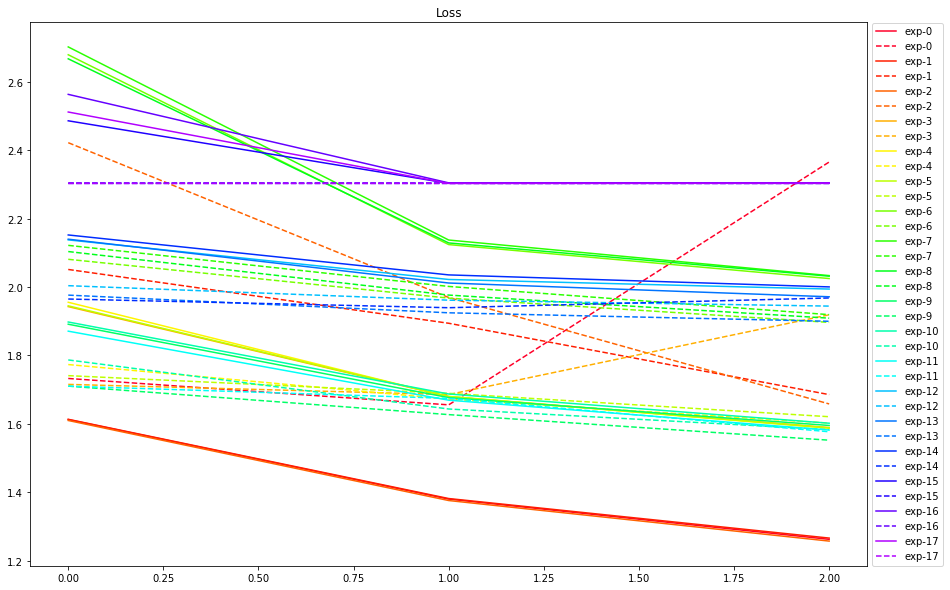

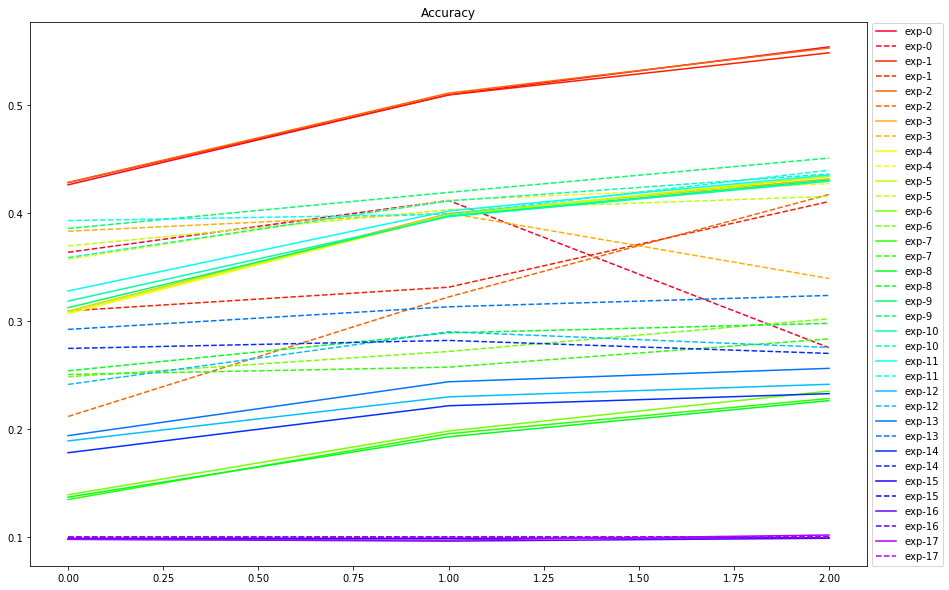

In [9]:
"""
Plot results
"""
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

import matplotlib.cm as mplcm
import matplotlib.colors as colors

NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]


for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure()

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))